In [1]:
using Revise

using Ipopt
using ForwardDiff
using Plots

In [2]:
const h = 0.05
const n_c = [0, 1]
const mass = 1.0
const G = [0, -9.81];

In [77]:
function contact_constraints(q0,v0)
    n = length(q0)
    
    function eval_g(x, g)
        q = x[1:n]
        v = x[n+1:2*n]
        λ = x[2*n+1]
        
        ϕ = n_c' * q 
        
        g[1:n] = mass * (v - v0) .- h * λ * n_c .- h * mass * G
        g[n+1:2*n] = q .- q0 .- h .* v
        g[2*n+1] = λ + ϕ - sqrt(λ^2 + ϕ^2)
    end
    
    function eval_jac_g(x, mode, rows, cols, values)
        if mode == :Structure
            # for now just assume dense jac
            for i = 1:(2*n+1)
                for j = 1:(2*n+1)
                    rows[(i-1)*(2*n+1)+j] = i
                    cols[(i-1)*(2*n+1)+j] = j
                end
            end
        else
            g = zeros(2*n+1)
            J = ForwardDiff.jacobian((g̃, x̃) -> eval_g(x̃, g̃), g, x)
            values[:] = J'[:]
        end
    end
    
    return eval_g, eval_jac_g
end
    
function simulate(q0, v0, N)
    results = vcat(q0,v0,0.)
    n = length(q0) + length(v0) + 1
    m = n
    
    function eval_f(x)
        return 0.
    end
    function eval_grad_f(x, grad_f)
        grad_f[:] = zeros(n)
    end
    
    for i in 1:N
        x_L = -1000. * ones(n)
        x_U = 1000. * ones(n)
    
        g_L = zeros(m)
        g_U = zeros(m)
        
        q = results[1:length(q0),end]
        v = results[length(q0)+1:length(q0)+length(v0),end]
        eval_g, eval_jac_g = contact_constraints(q,v)
        
        prob = createProblem(n, x_L, x_U, m, g_L, g_U, n*m, 0, eval_f, eval_g, eval_grad_f, eval_jac_g)
        
        prob.x = copy(results[:,end])
    
        addOption(prob, "hessian_approximation", "limited-memory")
        
        status = solveProblem(prob)   
        println(Ipopt.ApplicationReturnStatus[status])

        results = hcat(results,prob.x)
    end
    
    results
end

simulate (generic function with 1 method)

In [78]:
q0 = [-1, 0.5]
v0 = [2, 0.5]
N = 25
results = simulate(q0, v0, N)

This is Ipopt version 3.12.8, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:       25
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:        5
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        5
                     variables with only upper bounds:        0
Total number of equality constraints.................:        5
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

5×26 Array{Float64,2}:
 -1.0  -0.9       -0.8       -0.7      …   1.4           1.5        
  0.5   0.500475   0.476425   0.42785     -2.63883e-16  -2.63883e-16
  2.0   2.0        2.0        2.0          2.0           2.0        
  0.5   0.0095    -0.481     -0.9715      -2.29589e-41  -2.29589e-41
  0.0   0.0        0.0        0.0          9.81          9.81       

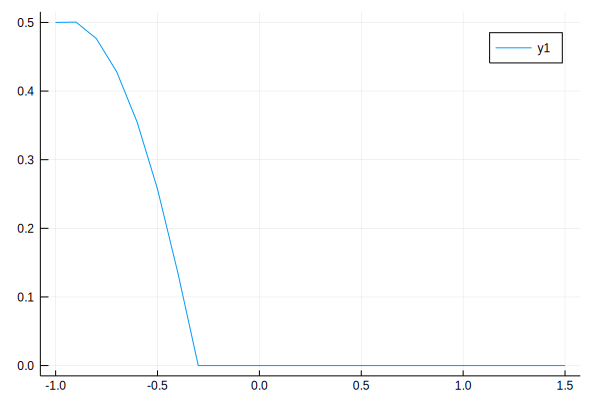

In [79]:
plot(results[1,:],results[2,:])

In [74]:
function complementarity_constraint(a,b,ϵ=1e-6)
    a + b - sqrt(a^2 + b^2 + ϵ)
end

function augmented_lagrangian(x,μ,λ,ϕ)
    constraint_val = complementarity_constraint(ϕ,x[1])
    .5 * μ * constraint_val^2 + λ * constraint_val
end

function ∇augmented_lagrangian(x,μ,λ,ϕ)
    ForwardDiff.gradient(x̃ -> augmented_lagrangian(x̃,μ,λ,ϕ),x)
end

function Haugmented_lagrangian(x,μ,λ,ϕ)
    ForwardDiff.jacobian(x̃ -> ∇augmented_lagrangian(x̃,μ,λ,ϕ),x)    
end

function newton_contact_forces(ϕ,λ0)
    N = 10
    α = .95
    μ = 1.
    I = 1e-16
    
    x = [0.] # [λ0] # contact force
    λ = 0. # lagrange multiplier
    
    for i = 1:N
        ∇al = ∇augmented_lagrangian(x,μ,λ,ϕ)
        Hal = Haugmented_lagrangian(x,μ,λ,ϕ)
        
        x = x - α^i .* ((Hal + I) \ ∇al)
        λ = λ + μ .* complementarity_constraint(ϕ,x[1])
        μ = μ * 5.
    end
    
    x[1]
end

function contact_constraints_implicit(q0,v0,λ0)
    num_x = length(q0) + length(v0)
    
    function eval_g(x, g)
        q = x[1:length(q0)]
        v = x[length(q0)+1:length(q0)+length(v0)]
    
        ϕ = n_c' * q
        
        g[1:length(v0)] = mass * (v - v0) .- h * newton_contact_forces(ϕ,λ0) * n_c .- h * mass * G
        g[length(v0)+1:length(v0)+length(q0)] = q .- q0 .- h .* v
    end
    
    function eval_jac_g(x, mode, rows, cols, values)
        num_x = length(q0)+length(v0)
        if mode == :Structure
            # for now just assume dense jac
            for i = 1:num_x
                for j = 1:num_x
                    rows[(i-1)*num_x+j] = i
                    cols[(i-1)*num_x+j] = j
                end
            end
        else
            g = zeros(num_x)
            J = ForwardDiff.jacobian((g̃, x̃) -> eval_g(x̃, g̃), g, x)
            values[:] = J'[:]
        end
    end
    
    return eval_g, eval_jac_g
end

function simulate_implicit(q0, v0, N)
    results = vcat(q0,v0,0.)
    n = size(q0,1) + size(v0,1)
    m = size(q0,1) + size(v0,1)
    
    function eval_f(x)
        return 0.
    end
    
    function eval_grad_f(x, grad_f)
        grad_f[:] = zeros(n)
    end
    
    for i in 1:N
        x_L = -1e6 * ones(n)
        x_U = 1e6 * ones(n)
    
        g_L = zeros(m)
        g_U = zeros(m)
        
        q0 = results[1:length(q0),end]
        v0 = results[length(q0)+1:length(q0)+length(v0),end]
        λ0 = results[length(q0)+length(v0)+1,end]
        eval_g, eval_jac_g = contact_constraints_implicit(q0,v0,λ0)
        
        prob = createProblem(n, x_L, x_U, m, g_L, g_U, n*m, 0, eval_f, eval_g, eval_grad_f, eval_jac_g)
        
        prob.x = copy(results[1:length(q0)+length(v0),end])
    
        addOption(prob, "hessian_approximation", "limited-memory")
        
        status = solveProblem(prob)   
        println(Ipopt.ApplicationReturnStatus[status])
    
        qnext = prob.x[1:length(q0)]
        ϕnext = n_c' * qnext
        λnext = newton_contact_forces(ϕnext,λ0)
        
        results = hcat(results,vcat(prob.x,λnext))
    end
    
    results
end

simulate_implicit (generic function with 1 method)

In [75]:
q0 = [-1, 0.5]
v0 = [2, 0.5]
N = 75
results = simulate_implicit(q0, v0, N)

This is Ipopt version 3.12.8, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:       16
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:        4
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        4
                     variables with only upper bounds:        0
Total number of equality constraints.................:        4
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

5×76 Array{Float64,2}:
 -1.0  -0.9         -0.8         …   6.3        6.4        6.5     
  0.5   0.500475     0.476425       -0.557201  -0.607937  -0.656867
  2.0   2.0          2.0             2.0        2.0        2.0     
  0.5   0.00950005  -0.481          -1.01161   -1.01472   -0.978596
  0.0   9.99051e-7   1.04948e-6      8.93433    9.74784   10.5324  

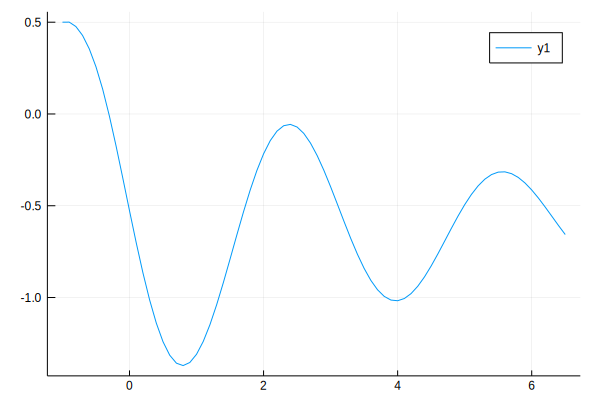

In [76]:
plot(results[1,:],results[2,:])

In [46]:
newton_contact_forces(2.,2.)

11.194429201375813